## Capstone - Respiratory Data Analysis

### Dataset description
General
   
   The demographic info file has 6 columns:
     - Patient number
     - Age
     - Sex
     - Adult BMI (kg/m2)
     - Child Weight (kg)
     - Child Height (cm)

  Each audio file name is divided into 5 elements, separated with underscores (_).
    1. Patient number (101,102,...,226)
    2. Recording index
    3. Chest location
        a. Trachea (Tc)
        b. Anterior left (Al)
        c. Anterior right (Ar)
        d. Posterior left (Pl)
        e. Posterior right (Pr)
        f. Lateral left (Ll)
        g. Lateral right (Lr)
    4. Acquisition mode
        a. sequential/single channel (sc),
        b. simultaneous/multichannel (mc)
    5. Recording equipment
        a. AKG C417L Microphone (AKGC417L),
        b. 3M Littmann Classic II SE Stethoscope (LittC2SE),
        c. 3M Litmmann 3200 Electronic Stethoscope (Litt3200),
        d.  WelchAllyn Meditron Master Elite Electronic Stethoscope (Meditron)
 The annotation text files have four columns:
     - Beginning of respiratory cycle(s)
     - End of respiratory cycle(s)
     - Presence/absence of crackles (presence=1, absence=0)
     - Presence/absence of wheezes (presence=1, absence=0)
 The abbreviations used in the diagnosis file are:
     - COPD: Chronic Obstructive Pulmonary Disease
     - LRTI: Lower Respiratory Tract Infection
     - URTI: Upper Respiratory Tract Infection

In [1]:
dataset_path='./dataset/Respiratory_dataset/'
demographic_info_file_name='demographic_info.txt'
patient_diagnosis_file_path=dataset_path + 'Respiratory_Sound_Database/'
patient_diagnosis_file_name='patient_diagnosis.csv'
audio_file_directory_path=dataset_path + 'Respiratory_Sound_Database/audio_and_txt_files/'
audio_file_directory_path

'./dataset/Respiratory_dataset/Respiratory_Sound_Database/audio_and_txt_files/'

In [2]:
import findspark
findspark.init()
import pyspark

In [3]:
sc = pyspark.SparkContext(appName="RespiratoryDataAnalysis",
                         master="local[2]").getOrCreate()
sc

<SparkContext master=local[2] appName=RespiratoryDataAnalysis>

In [4]:
num_partitions=2

In [5]:
from pyspark import SQLContext
sql_c = SQLContext(sc)



In [6]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType, FloatType
from pyspark.sql import DataFrame as df
from pyspark.sql import *

demographic_info_schema = StructType([
    StructField("patientId", StringType()),
    StructField("age", StringType()),
    StructField("sex", StringType()),
    StructField("adultBMI", StringType()),
    StructField("childWeight", StringType()),
    StructField("childHeight", StringType()),
])

patient_diagnosis_schema = StructType([
    StructField("patientId2", StringType()),
    StructField("diagnosis", StringType())])



In [7]:
rdd = sc.textFile(patient_diagnosis_file_path+demographic_info_file_name).map(lambda line: line.split(" "))
#rdd.map(lambda x: int(x[0])).map(lambda x:double(x[1]))
rdd.take(5)


[['101', '3', 'F', 'NA', '19', '99'],
 ['102', '0.75', 'F', 'NA', '9.8', '73'],
 ['103', '70', 'F', '33', 'NA', 'NA'],
 ['104', '70', 'F', '28.47', 'NA', 'NA'],
 ['105', '7', 'F', 'NA', '32', '135']]

In [8]:
rdd.count()

126

In [9]:
demographic_info_df = sql_c.createDataFrame(rdd, demographic_info_schema)

In [10]:
demographic_info_df.take(5)

[Row(patientId='101', age='3', sex='F', adultBMI='NA', childWeight='19', childHeight='99'),
 Row(patientId='102', age='0.75', sex='F', adultBMI='NA', childWeight='9.8', childHeight='73'),
 Row(patientId='103', age='70', sex='F', adultBMI='33', childWeight='NA', childHeight='NA'),
 Row(patientId='104', age='70', sex='F', adultBMI='28.47', childWeight='NA', childHeight='NA'),
 Row(patientId='105', age='7', sex='F', adultBMI='NA', childWeight='32', childHeight='135')]

In [11]:
demographic_info_df.patientId.cast("double")
demographic_info_df.age.cast("double")
demographic_info_df.dtypes

[('patientId', 'string'),
 ('age', 'string'),
 ('sex', 'string'),
 ('adultBMI', 'string'),
 ('childWeight', 'string'),
 ('childHeight', 'string')]

In [12]:
demographic_info_df.take(5)

[Row(patientId='101', age='3', sex='F', adultBMI='NA', childWeight='19', childHeight='99'),
 Row(patientId='102', age='0.75', sex='F', adultBMI='NA', childWeight='9.8', childHeight='73'),
 Row(patientId='103', age='70', sex='F', adultBMI='33', childWeight='NA', childHeight='NA'),
 Row(patientId='104', age='70', sex='F', adultBMI='28.47', childWeight='NA', childHeight='NA'),
 Row(patientId='105', age='7', sex='F', adultBMI='NA', childWeight='32', childHeight='135')]

In [13]:
patient_diagnosis_df = sql_c.read.format("csv").schema(patient_diagnosis_schema).load(patient_diagnosis_file_path+patient_diagnosis_file_name)

In [14]:
patient_diagnosis_df = patient_diagnosis_df.withColumn("patientId2", patient_diagnosis_df.patientId2.cast("int"))

In [15]:
patient_diagnosis_df.take(5)

[Row(patientId2=101, diagnosis='URTI'),
 Row(patientId2=102, diagnosis='Healthy'),
 Row(patientId2=103, diagnosis='Asthma'),
 Row(patientId2=104, diagnosis='COPD'),
 Row(patientId2=105, diagnosis='URTI')]

In [16]:
demographic_info_df = demographic_info_df.join(patient_diagnosis_df, demographic_info_df.patientId == patient_diagnosis_df.patientId2).drop(patient_diagnosis_df.patientId2)
demographic_info_df = demographic_info_df\
.withColumn("patientId", demographic_info_df["patientId"].cast("double")) \
.withColumn("age", demographic_info_df["age"].cast("double")) \
.withColumn("adultBMI", demographic_info_df["adultBMI"].cast("double"))\
.withColumn("childWeight", demographic_info_df["childWeight"].cast("double"))\
.withColumn("childHeight", demographic_info_df["childHeight"].cast("double"))\
#df1.join(df2, df1.col("column").equalTo(df2("column")));

In [17]:
demographic_info_df.take(5)

[Row(patientId=101.0, age=3.0, sex='F', adultBMI=None, childWeight=19.0, childHeight=99.0, diagnosis='URTI'),
 Row(patientId=102.0, age=0.75, sex='F', adultBMI=None, childWeight=9.8, childHeight=73.0, diagnosis='Healthy'),
 Row(patientId=103.0, age=70.0, sex='F', adultBMI=33.0, childWeight=None, childHeight=None, diagnosis='Asthma'),
 Row(patientId=104.0, age=70.0, sex='F', adultBMI=28.47, childWeight=None, childHeight=None, diagnosis='COPD'),
 Row(patientId=105.0, age=7.0, sex='F', adultBMI=None, childWeight=32.0, childHeight=135.0, diagnosis='URTI')]

In [18]:
demographic_info_df.describe().show()

+-------+-----------------+-----------------+----+------------------+------------------+------------------+---------+
|summary|        patientId|              age| sex|          adultBMI|       childWeight|       childHeight|diagnosis|
+-------+-----------------+-----------------+----+------------------+------------------+------------------+---------+
|  count|              126|              125| 126|                75|                44|                42|      126|
|   mean|            163.5|         42.99264|null|             27.19|21.361136363636362|104.65238095238094|     null|
| stddev|36.51711927302043|32.20907007961497|null|5.3725186604382085|17.150885015595605|30.793127504523998|     null|
|    min|            101.0|             0.25|   F|              16.5|              7.14|              64.0|   Asthma|
|    max|            226.0|             93.0|  NA|              53.5|              80.0|             183.0|     URTI|
+-------+-----------------+-----------------+----+------

In [19]:
demographic_info_df.summary().show()

+-------+-----------------+-----------------+----+------------------+------------------+------------------+---------+
|summary|        patientId|              age| sex|          adultBMI|       childWeight|       childHeight|diagnosis|
+-------+-----------------+-----------------+----+------------------+------------------+------------------+---------+
|  count|              126|              125| 126|                75|                44|                42|      126|
|   mean|            163.5|         42.99264|null|             27.19|21.361136363636362|104.65238095238094|     null|
| stddev|36.51711927302043|32.20907007961497|null|5.3725186604382085|17.150885015595605|30.793127504523998|     null|
|    min|            101.0|             0.25|   F|              16.5|              7.14|              64.0|   Asthma|
|    25%|            132.0|              4.0|null|              24.0|              11.5|              80.0|     null|
|    50%|            163.0|             60.0|null|      

Now we analyze the demographic information to have a first insight of the diagnoses, the repartition per population 

In [20]:
demographic_info_df.select('diagnosis').distinct().show()


+--------------+
|     diagnosis|
+--------------+
|          LRTI|
|Bronchiectasis|
| Bronchiolitis|
|          COPD|
|        Asthma|
|       Healthy|
|     Pneumonia|
|          URTI|
+--------------+



In [21]:
from pyspark.ml.feature import StringIndexer
df = demographic_info_df.alias("df")

indexer = StringIndexer(inputCol="diagnosis", outputCol="diagnosisIndex")
demographic_info_df = indexer.fit(demographic_info_df).transform(demographic_info_df)
indexer = StringIndexer(inputCol="sex", outputCol="sexIndex")
demographic_info_df = indexer.fit(demographic_info_df).transform(demographic_info_df)
demographic_info_df.show()

demographic_info_df.select('diagnosisIndex').distinct().show()

+---------+----+---+--------+-----------+-----------+--------------+--------------+--------+
|patientId| age|sex|adultBMI|childWeight|childHeight|     diagnosis|diagnosisIndex|sexIndex|
+---------+----+---+--------+-----------+-----------+--------------+--------------+--------+
|    101.0| 3.0|  F|    null|       19.0|       99.0|          URTI|           2.0|     1.0|
|    102.0|0.75|  F|    null|        9.8|       73.0|       Healthy|           1.0|     1.0|
|    103.0|70.0|  F|    33.0|       null|       null|        Asthma|           7.0|     1.0|
|    104.0|70.0|  F|   28.47|       null|       null|          COPD|           0.0|     1.0|
|    105.0| 7.0|  F|    null|       32.0|      135.0|          URTI|           2.0|     1.0|
|    106.0|73.0|  F|    21.0|       null|       null|          COPD|           0.0|     1.0|
|    107.0|75.0|  F|    33.7|       null|       null|          COPD|           0.0|     1.0|
|    108.0| 3.0|  M|    null|       null|       null|          LRTI|  

In [22]:
demographic_info_df.dtypes

[('patientId', 'double'),
 ('age', 'double'),
 ('sex', 'string'),
 ('adultBMI', 'double'),
 ('childWeight', 'double'),
 ('childHeight', 'double'),
 ('diagnosis', 'string'),
 ('diagnosisIndex', 'double'),
 ('sexIndex', 'double')]

In [23]:
demographic_info_df.cov( 'age', 'diagnosisIndex')

-20.814011428571426

## Now parsing audio file names and their annotation files
Filename format has 5 data:
1. Patient number (101,102,...,226)
2. Recording index
3. Chest location
    a. Trachea (Tc)
    b. Anterior left (Al)
    c. Anterior right (Ar)
    d. Posterior left (Pl)
    e. Posterior right (Pr)
    f. Lateral left (Ll)
    g. Lateral right (Lr)
4. Acquisition mode
    a. sequential/single channel (sc),
    b. simultaneous/multichannel (mc)
5. Recording equipment
    a. AKG C417L Microphone (AKGC417L),
    b. 3M Littmann Classic II SE Stethoscope (LittC2SE),
    c. 3M Litmmann 3200 Electronic Stethoscope (Litt3200),
    d.  WelchAllyn Meditron Master Elite Electronic Stethoscope (Meditron)

The annotation text files have four columns:
 - Beginning of respiratory cycle(s)
 - End of respiratory cycle(s)
 - Presence/absence of crackles (presence=1, absence=0)
 - Presence/absence of wheezes (presence=1, absence=0)

The following libraries are used to process the dataset:
- glob: directories and files I/O
- soundfile: read .wav file; see https://pysoundfile.readthedocs.io/en/0.9.0/
- librosa: resample audio files; used for audio signals normalization; see https://librosa.github.io/librosa/
- pywt (pywavelets): high-level wavelet processing; see https://pywavelets.readthedocs.io/en/latest/#main-features
- numpy
- scikit-learn: ML

Note:
TODO: enhance using sc.wholeTextFiles

In [24]:
import os
import io
import pywt
import matplotlib.pyplot as plt
import numpy as np
import glob
import librosa
import soundfile as sf

In [25]:
%matplotlib inline

In [26]:
audio_file_columns = ['patientId', 
                      'recIndex', 
                      'chLoc', 
                      'acqMode', 
                      'recEqpt', 
                      'fileId', 
                      'file_name_base', 
                      'sample_rate'
                      , 'sample_length'
                     ]

ann_rec_file_columns = ["patientId", 
                        "recIndex", 
                      "chLoc", 
                      "acqMode", 
                      "recEqpt", 
                      "fileId", 
                      "file_name_base",
                        "annot"]

audio_file_schema = StructType([
    StructField("patientId", StringType()),
    StructField("recIndex", IntegerType()),
    StructField("chLoc", StringType()),
    StructField("acqMode", StringType()),
    StructField("recEqpt", StringType()),
    StructField("fileId", StringType()),
    StructField("file_name_base", StringType()),
    StructField("sample_rate", IntegerType())
])

ann_rec_file_schema = StructType([
    StructField("begin", DoubleType()),
    StructField("end", DoubleType()),
    StructField("crackles", IntegerType()),
    StructField("wheezes", IntegerType())
])

In [27]:
separator = '_'
audio_file_fields = []
audio_list =[]
for file_name in glob.iglob(audio_file_directory_path + '*.wav', recursive=False):
    file_name_base = os.path.basename(file_name)
    fileId = file_name_base.split('.')[0]
    file_field = fileId.split(separator)
    file_field.append(fileId)
    file_field.append(file_name_base)
    #reading audio file
    print('.', end='')
    data, sample_rate = sf.read(file_name)
    file_field.append(sample_rate)
    file_field.append(len(data))
    audio_list.append([file_name_base, file_field[0], file_field[1], data.tolist()])
    audio_file_fields.append(file_field)
audio_file_fields[:2]

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[['122',
  '2b1',
  'Tc',
  'mc',
  'LittC2SE',
  '122_2b1_Tc_mc_LittC2SE',
  '122_2b1_Tc_mc_LittC2SE.wav',
  44100,
  882000],
 ['113',
  '1b1',
  'Lr',
  'sc',
  'Litt3200',
  '113_1b1_Lr_sc_Litt3200',
  '113_1b1_Lr_sc_Litt3200.wav',
  4000,
  58304]]

In [28]:
#reading annotation files
import csv
annot_file_fields = []
for file_name in glob.iglob(audio_file_directory_path + '*.txt', recursive=False):
    file_name_base = os.path.basename(file_name)
    fileId = file_name_base.split('.')[0]
    file_field = fileId.split(separator)
    file_field.append(fileId)
    file_field.append(file_name_base)
    
    #reading annotation files
    myFile= open(file_name)
    ann_data = csv.reader(myFile, delimiter='\t')
    file_field.append([ann for ann in ann_data])
    annot_file_fields.append(file_field)
    myFile.close()

annot_file_fields[:2]

[['148',
  '1b1',
  'Al',
  'sc',
  'Meditron',
  '148_1b1_Al_sc_Meditron',
  '148_1b1_Al_sc_Meditron.txt',
  [['0.022', '0.364', '0', '0'],
   ['0.364', '2.436', '0', '0'],
   ['2.436', '4.636', '0', '0'],
   ['4.636', '6.793', '0', '0'],
   ['6.793', '8.75', '0', '0'],
   ['8.75', '10.764', '0', '0'],
   ['10.764', '13.05', '0', '0'],
   ['13.05', '15.193', '0', '0'],
   ['15.193', '17.179', '0', '0'],
   ['17.179', '19.05', '0', '0'],
   ['19.05', '19.993', '0', '0']]],
 ['130',
  '3p2',
  'Tc',
  'mc',
  'AKGC417L',
  '130_3p2_Tc_mc_AKGC417L',
  '130_3p2_Tc_mc_AKGC417L.txt',
  [['1.461', '2.918', '1', '0'],
   ['2.918', '5.839', '1', '0'],
   ['5.839', '8.605', '1', '0'],
   ['8.605', '11.637', '1', '0'],
   ['11.637', '14.492', '1', '0'],
   ['14.492', '17.389', '1', '0'],
   ['17.389', '18.796', '1', '0']]]]

Create the complete dataframe by joining all extracted array data and data frame in to a single data frame:
 - demographic_info_df
 - audio_file_fields
 - annot_file_fields

In [29]:
df = sql_c.createDataFrame(audio_file_fields, schema=audio_file_columns)
df2 = demographic_info_df.join(df, demographic_info_df.patientId == df.patientId).drop(df.patientId)
df2.take(1)

[Row(patientId=147.0, age=77.0, sex='M', adultBMI=25.7, childWeight=None, childHeight=None, diagnosis='COPD', diagnosisIndex=0.0, sexIndex=0.0, recIndex='1b3', chLoc='Tc', acqMode='mc', recEqpt='AKGC417L', fileId='147_1b3_Tc_mc_AKGC417L', file_name_base='147_1b3_Tc_mc_AKGC417L.wav', sample_rate=44100, sample_length=882000)]

In [30]:
df2.summary().show()

+-------+------------------+------------------+----+-----------------+------------------+------------------+---------+-------------------+------------------+--------+-----+-------+--------+--------------------+--------------------+------------------+-----------------+
|summary|         patientId|               age| sex|         adultBMI|       childWeight|       childHeight|diagnosis|     diagnosisIndex|          sexIndex|recIndex|chLoc|acqMode| recEqpt|              fileId|      file_name_base|       sample_rate|    sample_length|
+-------+------------------+------------------+----+-----------------+------------------+------------------+---------+-------------------+------------------+--------+-----+-------+--------+--------------------+--------------------+------------------+-----------------+
|  count|               920|               914| 920|              835|                69|                67|      920|                920|               920|     920|  920|    920|     920|    

In [31]:
df = sql_c.createDataFrame(annot_file_fields, schema=ann_rec_file_columns)
df.take(1)

[Row(patientId='148', recIndex='1b1', chLoc='Al', acqMode='sc', recEqpt='Meditron', fileId='148_1b1_Al_sc_Meditron', file_name_base='148_1b1_Al_sc_Meditron.txt', annot=[['0.022', '0.364', '0', '0'], ['0.364', '2.436', '0', '0'], ['2.436', '4.636', '0', '0'], ['4.636', '6.793', '0', '0'], ['6.793', '8.75', '0', '0'], ['8.75', '10.764', '0', '0'], ['10.764', '13.05', '0', '0'], ['13.05', '15.193', '0', '0'], ['15.193', '17.179', '0', '0'], ['17.179', '19.05', '0', '0'], ['19.05', '19.993', '0', '0']])]

Proceeding with sample statistics on the loaded data

In [32]:
df2.groupBy('sample_rate').count().show()

+-----------+-----+
|sample_rate|count|
+-----------+-----+
|      10000|    6|
|       4000|   90|
|      44100|  824|
+-----------+-----+



In [33]:
df2.groupBy('sample_length').count().show()

+-------------+-----+
|sample_length|count|
+-------------+-----+
|       248200|    2|
|       874503|    1|
|        61888|    1|
|        65472|    1|
|       882000|  801|
|       344800|    1|
|       873180|    1|
|       882001|   16|
|        78528|    3|
|        87488|    1|
|        50112|    2|
|        58304|    4|
|       117440|    1|
|       107712|    1|
|        83392|    2|
|        69824|    1|
|        81344|    2|
|        94912|    1|
|       252400|    2|
|       332000|    2|
+-------------+-----+
only showing top 20 rows



In [34]:
df2.select('sample_length').summary().show()

+-------+-----------------+
|summary|    sample_length|
+-------+-----------------+
|  count|              920|
|   mean|805551.7989130435|
| stddev|226261.0482416206|
|    min|            31424|
|    25%|           882000|
|    50%|           882000|
|    75%|           882000|
|    max|           882001|
+-------+-----------------+



In [35]:
df2.groupBy('sample_length').count().orderBy('sample_length', ascending=False).show()

+-------------+-----+
|sample_length|count|
+-------------+-----+
|       882001|   16|
|       882000|  801|
|       881118|    1|
|       880677|    1|
|       879795|    1|
|       874944|    1|
|       874503|    1|
|       874062|    1|
|       873180|    1|
|       344800|    1|
|       339000|    2|
|       332000|    2|
|       330000|    1|
|       329000|    2|
|       301000|    1|
|       297800|    1|
|       293400|    1|
|       285800|    1|
|       284200|    2|
|       277800|    1|
+-------------+-----+
only showing top 20 rows



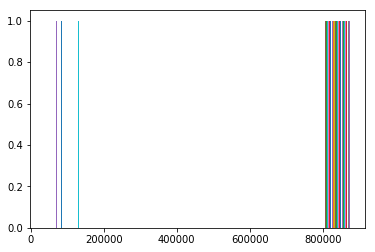

In [36]:
sample_length_list = df2.select('sample_length').rdd.collect()
plt.hist(sample_length_list)
plt.show()

In [37]:
df2.groupBy('diagnosis').count().show()

+--------------+-----+
|     diagnosis|count|
+--------------+-----+
|          LRTI|    2|
|Bronchiectasis|   16|
| Bronchiolitis|   13|
|          COPD|  793|
|        Asthma|    1|
|       Healthy|   35|
|     Pneumonia|   37|
|          URTI|   23|
+--------------+-----+



In [38]:
#df2 = df2.join(df, (df2.patientId == df.patientId) & (df2.recIndex == df.recIndex)) \
df2 = df2.join(df, ['patientId', 'recIndex', 'chLoc', 'acqMode', 'fileId', 'file_name_base'], 'left_outer')\
.drop(df.patientId) \
.drop(df.recIndex) \
.drop(df.chLoc) \
.drop(df.acqMode) \
.drop(df.fileId) \
.drop(df.file_name_base) \
.drop(df.recEqpt)


In [39]:
# Applying StringIndexer on remaining enumarates: "chLoc", "acqMode", "recEqpt"
indexer = StringIndexer(inputCol="chLoc", outputCol="chLocIndex")
df2 = indexer.fit(df2).transform(df2)
indexer = StringIndexer(inputCol="acqMode", outputCol="acqModeIndex")
df2 = indexer.fit(df2).transform(df2)
indexer = StringIndexer(inputCol="recEqpt", outputCol="recEqptIndex")
df2 = indexer.fit(df2).transform(df2)


In [40]:
df2.describe().show()

+-------+------------------+--------+-----+-------+--------------------+--------------------+------------------+----+------------------+------------------+------------------+---------+-------------------+-------------------+--------+------------------+-----------------+------------------+-------------------+------------------+
|summary|         patientId|recIndex|chLoc|acqMode|              fileId|      file_name_base|               age| sex|          adultBMI|       childWeight|       childHeight|diagnosis|     diagnosisIndex|           sexIndex| recEqpt|       sample_rate|    sample_length|        chLocIndex|       acqModeIndex|      recEqptIndex|
+-------+------------------+--------+-----+-------+--------------------+--------------------+------------------+----+------------------+------------------+------------------+---------+-------------------+-------------------+--------+------------------+-----------------+------------------+-------------------+------------------+
|  count|    

In [41]:
df2.select('patientId', 'recIndex', 'age', 'adultBMI', 'childWeight', 'childHeight', 'sample_rate').summary().show()

+-------+------------------+--------+------------------+------------------+------------------+------------------+------------------+
|summary|         patientId|recIndex|               age|          adultBMI|       childWeight|       childHeight|       sample_rate|
+-------+------------------+--------+------------------+------------------+------------------+------------------+------------------+
|  count|               920|     920|               914|               835|                69|                67|               920|
|   mean|164.35978260869564|    null|63.776706783369804|26.022311377245504|19.568115942028985|101.35522388059701|39954.782608695656|
| stddev|32.025253772128465|    null| 20.05620251024337| 5.177936085851482|15.341684495609677|27.872780702968704|12160.047988839648|
|    min|             101.0|     1b1|              0.25|              16.5|              7.14|              64.0|              4000|
|    25%|             138.0|    null|              61.0|             

The structure of the df2 data frame is now the following:

In [42]:
df2.dtypes

[('patientId', 'double'),
 ('recIndex', 'string'),
 ('chLoc', 'string'),
 ('acqMode', 'string'),
 ('fileId', 'string'),
 ('file_name_base', 'string'),
 ('age', 'double'),
 ('sex', 'string'),
 ('adultBMI', 'double'),
 ('childWeight', 'double'),
 ('childHeight', 'double'),
 ('diagnosis', 'string'),
 ('diagnosisIndex', 'double'),
 ('sexIndex', 'double'),
 ('recEqpt', 'string'),
 ('sample_rate', 'bigint'),
 ('sample_length', 'bigint'),
 ('annot', 'array<array<string>>'),
 ('chLocIndex', 'double'),
 ('acqModeIndex', 'double'),
 ('recEqptIndex', 'double')]

## Data analysis

In [43]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation, ChiSquareTest

In [44]:
df2.filter(df2.patientId == 101).show()
df2.filter(df2.age > 60).show(1)

+---------+--------+-----+-------+--------------------+--------------------+---+---+--------+-----------+-----------+---------+--------------+--------+--------+-----------+-------------+-----+----------+------------+------------+
|patientId|recIndex|chLoc|acqMode|              fileId|      file_name_base|age|sex|adultBMI|childWeight|childHeight|diagnosis|diagnosisIndex|sexIndex| recEqpt|sample_rate|sample_length|annot|chLocIndex|acqModeIndex|recEqptIndex|
+---------+--------+-----+-------+--------------------+--------------------+---+---+--------+-----------+-----------+---------+--------------+--------+--------+-----------+-------------+-----+----------+------------+------------+
|    101.0|     1b1|   Al|     sc|101_1b1_Al_sc_Med...|101_1b1_Al_sc_Med...|3.0|  F|    null|       19.0|       99.0|     URTI|           2.0|     1.0|Meditron|      44100|       882000| null|       1.0|         1.0|         1.0|
|    101.0|     1b1|   Pr|     sc|101_1b1_Pr_sc_Med...|101_1b1_Pr_sc_Med...|3.0|

In [45]:
df2.dropna()
df2.describe().show()

+-------+------------------+--------+-----+-------+--------------------+--------------------+------------------+----+------------------+------------------+------------------+---------+-------------------+-------------------+--------+------------------+-----------------+------------------+-------------------+------------------+
|summary|         patientId|recIndex|chLoc|acqMode|              fileId|      file_name_base|               age| sex|          adultBMI|       childWeight|       childHeight|diagnosis|     diagnosisIndex|           sexIndex| recEqpt|       sample_rate|    sample_length|        chLocIndex|       acqModeIndex|      recEqptIndex|
+-------+------------------+--------+-----+-------+--------------------+--------------------+------------------+----+------------------+------------------+------------------+---------+-------------------+-------------------+--------+------------------+-----------------+------------------+-------------------+------------------+
|  count|    

In order to run statistics method on the selected columns of the dataset, we build a feature model using VectorAssembler

In [46]:
features_columns=['diagnosisIndex','age','sexIndex','adultBMI', 'sample_rate', 'sample_length', 'chLocIndex','acqModeIndex','recEqptIndex']
vectorAssembler = VectorAssembler(inputCols=features_columns, outputCol="features", handleInvalid='skip' )
features = vectorAssembler.setParams(handleInvalid="skip").transform(df2)
features.dtypes


[('patientId', 'double'),
 ('recIndex', 'string'),
 ('chLoc', 'string'),
 ('acqMode', 'string'),
 ('fileId', 'string'),
 ('file_name_base', 'string'),
 ('age', 'double'),
 ('sex', 'string'),
 ('adultBMI', 'double'),
 ('childWeight', 'double'),
 ('childHeight', 'double'),
 ('diagnosis', 'string'),
 ('diagnosisIndex', 'double'),
 ('sexIndex', 'double'),
 ('recEqpt', 'string'),
 ('sample_rate', 'bigint'),
 ('sample_length', 'bigint'),
 ('annot', 'array<array<string>>'),
 ('chLocIndex', 'double'),
 ('acqModeIndex', 'double'),
 ('recEqptIndex', 'double'),
 ('features', 'vector')]

In [47]:
features.show(2)

+---------+--------+-----+-------+--------------------+--------------------+----+---+--------+-----------+-----------+---------+--------------+--------+--------+-----------+-------------+-----+----------+------------+------------+--------------------+
|patientId|recIndex|chLoc|acqMode|              fileId|      file_name_base| age|sex|adultBMI|childWeight|childHeight|diagnosis|diagnosisIndex|sexIndex| recEqpt|sample_rate|sample_length|annot|chLocIndex|acqModeIndex|recEqptIndex|            features|
+---------+--------+-----+-------+--------------------+--------------------+----+---+--------+-----------+-----------+---------+--------------+--------+--------+-----------+-------------+-----+----------+------------+------------+--------------------+
|    112.0|     1p1|   Pl|     sc|112_1p1_Pl_sc_Lit...|112_1p1_Pl_sc_Lit...|60.0|  M|   22.86|       null|       null|     COPD|           0.0|     0.0|Litt3200|       4000|       120000| null|       2.0|         1.0|         3.0|[0.0,60.0,0.0,

In [48]:
r1 = Correlation.corr(features, 'features').collect()[0][0]
print(str(r1))

DenseMatrix([[ 1.        , -0.00661748,  0.00217342,  0.03941484,  0.08472475,
               0.08409312, -0.04697581,  0.06797668,  0.34662033],
             [-0.00661748,  1.        ,  0.08972432, -0.06386707, -0.0229052 ,
              -0.01799415,  0.03844565, -0.04760087,  0.00801117],
             [ 0.00217342,  0.08972432,  1.        , -0.15302941,  0.14702719,
               0.13924681, -0.01543362, -0.08655962, -0.10532605],
             [ 0.03941484, -0.06386707, -0.15302941,  1.        , -0.28592444,
              -0.27341424, -0.02909962,  0.27963644,  0.2333162 ],
             [ 0.08472475, -0.0229052 ,  0.14702719, -0.28592444,  1.        ,
               0.99254246, -0.0181849 , -0.90917138, -0.69051857],
             [ 0.08409312, -0.01799415,  0.13924681, -0.27341424,  0.99254246,
               1.        , -0.02278769, -0.90239095, -0.72061131],
             [-0.04697581,  0.03844565, -0.01543362, -0.02909962, -0.0181849 ,
              -0.02278769,  1.        ,  0.00

In [49]:
r1 = Correlation.corr(features, 'features', method='spearman').collect()[0][0]
print(features_columns)
print(r1.toArray())

['diagnosisIndex', 'age', 'sexIndex', 'adultBMI', 'sample_rate', 'sample_length', 'chLocIndex', 'acqModeIndex', 'recEqptIndex']
[[ 1.         -0.00737776  0.02332551  0.03097751  0.08694457  0.27387646
  -0.04640586  0.1373927   0.42659087]
 [-0.00737776  1.          0.07584418 -0.05592905 -0.0142274  -0.04809394
   0.03834467 -0.03018095 -0.00426754]
 [ 0.02332551  0.07584418  1.         -0.13389052  0.14702719  0.17585775
  -0.01271434 -0.08655962 -0.10435824]
 [ 0.03097751 -0.05592905 -0.13389052  1.         -0.21226165 -0.17773741
  -0.02228532  0.21895535  0.20310821]
 [ 0.08694457 -0.0142274   0.14702719 -0.21226165  1.          0.92637915
  -0.01452617 -0.90917138 -0.66680761]
 [ 0.27387646 -0.04809394  0.17585775 -0.17773741  0.92637915  1.
  -0.02498228 -0.68734317 -0.53759229]
 [-0.04640586  0.03834467 -0.01271434 -0.02228532 -0.01452617 -0.02498228
   1.          0.00193338 -0.04146903]
 [ 0.1373927  -0.03018095 -0.08655962  0.21895535 -0.90917138 -0.68734317
   0.00193338  

### Test of the independence of each column of the feature against the label "diagnosisIndex"
For this a Chi Square independence test is run.
The follwing features are tested for independence against the diagnosis: 'age', sex', adultBMI', 'chLoc', 'acqMode', 'recEqpt'.

In [50]:
chiSquareResult = ChiSquareTest.test(features, 'features', 'diagnosisIndex')

In [51]:
print(features_columns)

['diagnosisIndex', 'age', 'sexIndex', 'adultBMI', 'sample_rate', 'sample_length', 'chLocIndex', 'acqModeIndex', 'recEqptIndex']


In [52]:
chiSquareResult.select("pValues").collect()[0]

Row(pValues=DenseVector([0.0, 0.0, 0.0009, 0.0, 0.0971, 0.0, 0.0434, 0.0, 0.0]))

pValues less than 0.05 give a very strong presumption against the null hypothesis. We thus cannot accept the hypothesis of independence based on these data. Hence the only hypothesis that cannot be strongly presumpted against is regarding the relationship between 'sample rate' and diagnosis.

In [53]:
chiSquareResult.select("degreesOfFreedom").collect()[0]

Row(degreesOfFreedom=[9, 90, 3, 195, 3, 186, 18, 3, 9])

In [54]:
chiSquareResult.select("statistics").collect()[0]

Row(statistics=DenseVector([2505.0, 573.3118, 16.5716, 1545.7253, 6.3177, 839.4304, 29.4249, 119.7455, 617.7172]))

We can infer that the diagnosis does not statistically depend of the selected features 'age', sex', adultBMI', 'chLoc', 'acqMode', 'recEqpt'.
We need to dig into the recorded samples through audio signal processing.


#  Audio Signal data preprocessing

For the signal analysis, we will use the data previously loaded in:
- audio_file_fields = []
- audio_list =[]
- annot_file_fields =[]


First let's take a look at how the audio recordings looks like by displaying a sample, one for each diagnosis type 

In [55]:
diagnosisType = df2.groupBy('diagnosis').count()
diagnosisTypeList = diagnosisType.rdd.map(lambda x : x.diagnosis).collect()
diagnosisTypeList

['LRTI',
 'Bronchiectasis',
 'Bronchiolitis',
 'COPD',
 'Asthma',
 'Healthy',
 'Pneumonia',
 'URTI']

In [56]:
diagnosisType.show()

+--------------+-----+
|     diagnosis|count|
+--------------+-----+
|          LRTI|    2|
|Bronchiectasis|   16|
| Bronchiolitis|   13|
|          COPD|  793|
|        Asthma|    1|
|       Healthy|   35|
|     Pneumonia|   37|
|          URTI|   23|
+--------------+-----+



Now let's pick one record for each diagnosis, and display it on a diagram.
For this:
1. select one record in df2 giving (patientId, recIndex, sample_rate, sample_length)
2. select the corresponding recording audio in audio_list where the key is (patientId, recId)
3. display

In [57]:
rec_columns=['file_name_base','patientId', 'recIndex', 'sample_rate', 'sample_length','diagnosis','diagnosisIndex']

In [58]:
diagnosisTypeSample = []
for diagnosisTypeEnum in diagnosisTypeList :
    rec = df2.filter(df2.diagnosis == diagnosisTypeEnum)\
    .select(rec_columns)\
    .rdd\
    .map(lambda x : [x[0],x[1],x[2],x[3],x[4],x[5], x[6]])\
    .collect()[0]
    diagnosisTypeSample.append(rec)

In [59]:
print(diagnosisTypeSample)

[['108_1b1_Al_sc_Meditron.wav', 108.0, '1b1', 44100, 882000, 'LRTI', 6.0], ['111_1b2_Tc_sc_Meditron.wav', 111.0, '1b2', 44100, 882001, 'Bronchiectasis', 3.0], ['206_1b1_Ar_sc_Meditron.wav', 206.0, '1b1', 44100, 882000, 'Bronchiolitis', 4.0], ['112_1p1_Pl_sc_Litt3200.wav', 112.0, '1p1', 4000, 120000, 'COPD', 0.0], ['103_2b2_Ar_mc_LittC2SE.wav', 103.0, '2b2', 44100, 882000, 'Asthma', 7.0], ['125_1b1_Tc_sc_Meditron.wav', 125.0, '1b1', 44100, 882000, 'Healthy', 1.0], ['135_2b2_Al_mc_LittC2SE.wav', 135.0, '2b2', 44100, 882000, 'Pneumonia', 5.0], ['101_1b1_Al_sc_Meditron.wav', 101.0, '1b1', 44100, 882000, 'URTI', 2.0]]


In [60]:
import pandas as pd
pdSample = pd.DataFrame(diagnosisTypeSample, columns=rec_columns)
pdSample

,file_name_base,patientId,recIndex,sample_rate,sample_length,diagnosis,diagnosisIndex
0,108_1b1_Al_sc_Meditron.wav,108.0,1b1,44100,882000,LRTI,6.0
1,111_1b2_Tc_sc_Meditron.wav,111.0,1b2,44100,882001,Bronchiectasis,3.0
2,206_1b1_Ar_sc_Meditron.wav,206.0,1b1,44100,882000,Bronchiolitis,4.0
3,112_1p1_Pl_sc_Litt3200.wav,112.0,1p1,4000,120000,COPD,0.0
4,103_2b2_Ar_mc_LittC2SE.wav,103.0,2b2,44100,882000,Asthma,7.0
5,125_1b1_Tc_sc_Meditron.wav,125.0,1b1,44100,882000,Healthy,1.0
6,135_2b2_Al_mc_LittC2SE.wav,135.0,2b2,44100,882000,Pneumonia,5.0
7,101_1b1_Al_sc_Meditron.wav,101.0,1b1,44100,882000,URTI,2.0


Now from this panda data frame we can retrieve the audio file for each row

In [61]:
#audio_list[0]

In [62]:
#audio_file_fields
#annot_file_fields
#audio_list
audio_list_dict = {}
for index in range(len(audio_list)):
    audio_list_dict[audio_list[index][0]] = audio_list[index][3]

In [63]:
#audio_list_dict[pdSample.recIndex[0]]

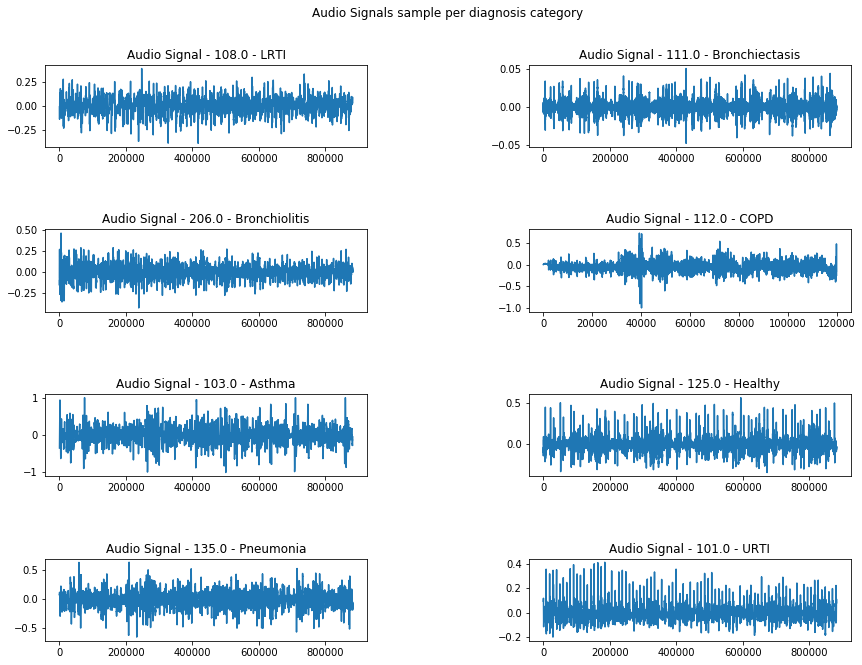

In [64]:
fig = plt.figure(figsize=(14,10))
plt.gcf().subplots_adjust(left = 0.1, bottom = 0.1,
                       right = 0.9, top = 0.9, wspace = 0.5, hspace = 1)
fig.suptitle("Audio Signals sample per diagnosis category")
layout = [421,422,423,424,425,426,427,428] # to be generized
for index in range(len(layout)):
    ax1 = plt.subplot(layout[index])
    ax1.set_title("Audio Signal - " + str(pdSample.patientId[index]) + " - " + diagnosisTypeList[index])
    plt.plot(audio_list_dict[pdSample.file_name_base[index]])
plt.show()

We separate the sample audio according to the annotation file, 

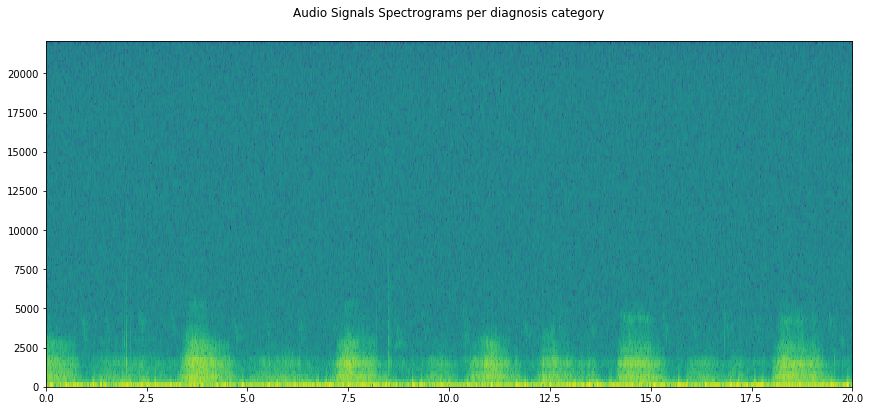

In [65]:
fig = plt.figure(figsize=(14,6))
plt.gcf().subplots_adjust(left = 0.1, bottom = 0.1,
                       right = 0.9, top = 0.9, wspace = 0.5, hspace = 1)
index=5
fig.suptitle("Audio Signals Spectrograms per diagnosis category")

ax1.set_xlabel('Time')
ax1.set_ylabel('Frequency')
ax1.set_title("Audio Signal Spectrograms - " + diagnosisTypeList[index])
powerSpectrum, frequenciesFound, time, imageAxis = \
               plt.specgram(audio_list_dict[pdSample.file_name_base[index]], Fs=pdSample.sample_rate[index])

plt.show()

/Users/famillenassivet/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7221: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


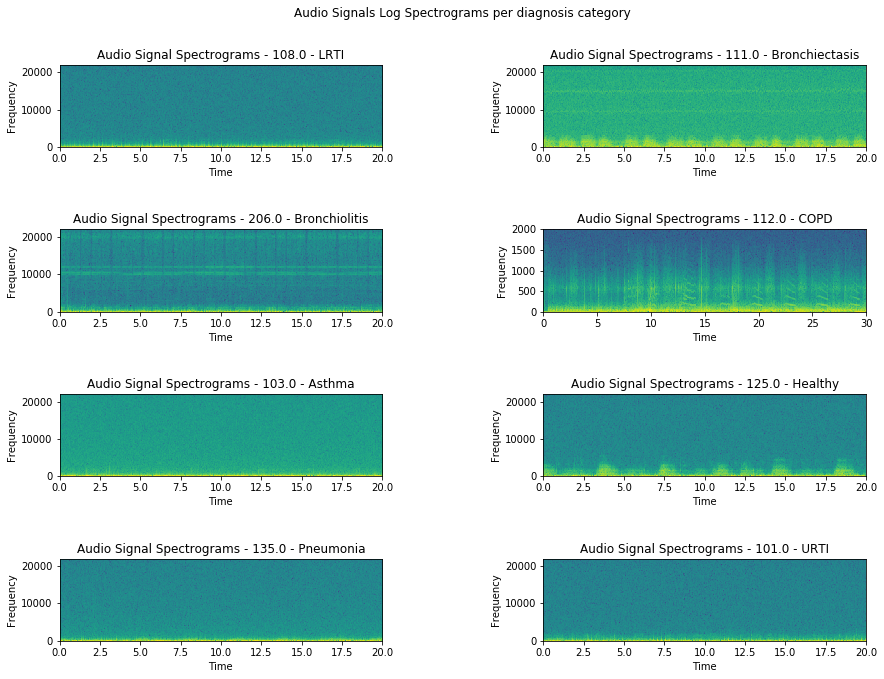

In [66]:
from librosa.display import *

fig = plt.figure(figsize=(14,10))
plt.gcf().subplots_adjust(left = 0.1, bottom = 0.1,
                       right = 0.9, top = 0.9, wspace = 0.5, hspace = 1)
fig.suptitle("Audio Signals Log Spectrograms per diagnosis category")
layout = [421,422,423,424,425,426,427,428]
for index in range(len(layout)):
    ax1 = plt.subplot(layout[index])
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Frequency')
    ax1.set_title("Audio Signal Spectrograms - " + str(pdSample.patientId[index]) + " - "  + diagnosisTypeList[index])
    powerSpectrum, frequenciesFound, time, imageAxis = \
               plt.specgram(audio_list_dict[pdSample.file_name_base[index]], Fs=pdSample.sample_rate[index])

plt.show()

Spectrograms show specific signatures for the different respiratory diseases picked-up in the sample, except LRTI and URTI which are very similar, and pneumonia which is close to the 2 above. This is even clearer when looking at spectrograms with a logarithmic scale, as below.

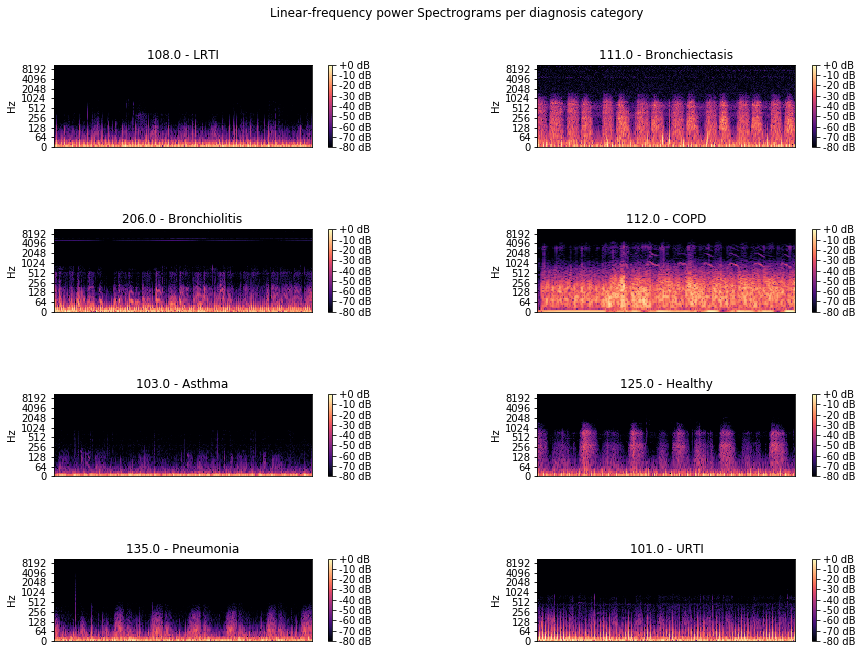

In [67]:
from librosa.display import *

fig = plt.figure(figsize=(14,10))
plt.gcf().subplots_adjust(left = 0.1, bottom = 0.1,
                       right = 0.9, top = 0.9, wspace = 0.5, hspace = 1)
fig.suptitle("Linear-frequency power Spectrograms per diagnosis category")
layout = [421,422,423,424,425,426,427,428]
for index in range(len(layout)):
    ax1 = plt.subplot(layout[index])
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Frequency')
    ax1.set_title(str(pdSample.patientId[index]) + " - "+ diagnosisTypeList[index])
    D = librosa.amplitude_to_db(np.abs(librosa.stft(np.asarray(audio_list_dict[pdSample.file_name_base[index]]))), ref=np.max)
    librosa.display.specshow(D, y_axis='log')
    plt.colorbar(format='%+2.0f dB')

plt.show()

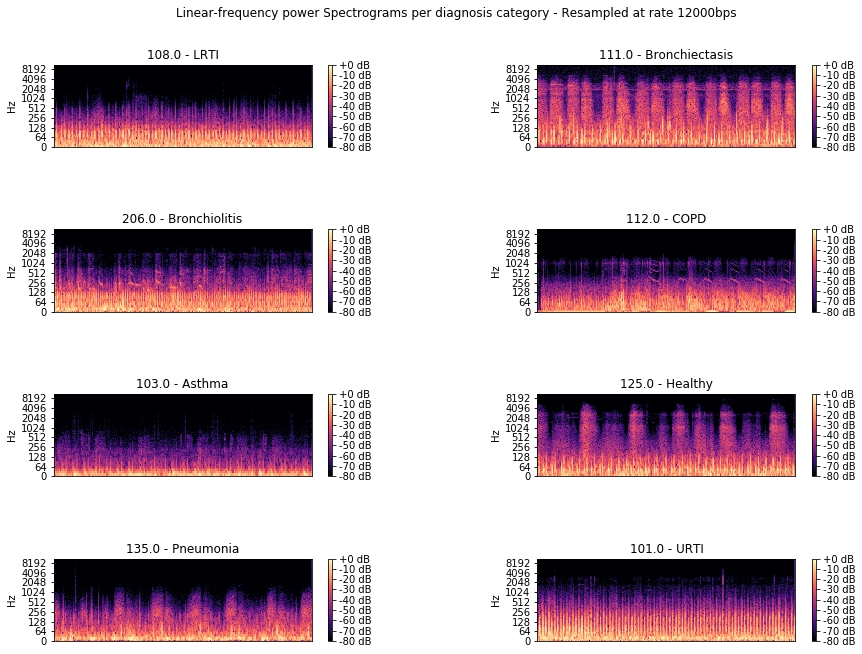

In [68]:
from librosa.display import *
from librosa import core as lcore
lengths=[]

fig = plt.figure(figsize=(14,10))
plt.gcf().subplots_adjust(left = 0.1, bottom = 0.1,
                       right = 0.9, top = 0.9, wspace = 0.5, hspace = 1)
fig.suptitle("Linear-frequency power Spectrograms per diagnosis category - Resampled at rate 12000bps")
layout = [421,422,423,424,425,426,427,428]
for index in range(len(layout)):
    ax1 = plt.subplot(layout[index])
    resampled = lcore.resample(np.asarray(audio_list_dict[pdSample.file_name_base[index]]),\
                               orig_sr=pdSample.sample_rate[index],\
                               target_sr=12000)
    lengths.append(len(resampled))
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Frequency')
    ax1.set_title(str(pdSample.patientId[index]) + " - "+ diagnosisTypeList[index])
    D = librosa.amplitude_to_db(np.abs(librosa.stft(resampled)), ref=np.max)
    librosa.display.specshow(D, y_axis='log')
    plt.colorbar(format='%+2.0f dB')

plt.show()

In [69]:
print(lengths)

[240001, 240001, 240001, 360000, 240001, 240001, 240001, 240001]


On the selected samples, resampling at 12000 (instead of 44100 mainly) keep the signals shape. Thus all the samples will be resampled for dimensionality reduction.

## Feature extraction from audio sample

Sound feature is constructed from audio_list (constructed as: [file_name_base, patientId, recordId, sample_data]) augmented with diagnosisIndex. The sample data is also refactored to be sampled at rate target_rate=12000 and split in smaller records of size target_length.

In [70]:
def resample_and_mfcc (sample, sample_rate, target_rate):
    # fonction to resample a time serie and return the corresponding mfcc
    from librosa import core as lcore
    resampled = lcore.resample(np.asarray(sample),\
                           orig_sr=sample_rate,\
                           target_sr=target_rate)
    mfcc = np.mean(librosa.feature.mfcc(y=resampled, sr=target_rate, n_mfcc=40).T, axis=0)
    return mfcc

In [71]:
def split_sample(source, output_length):
    copy = np.zeros(output_length, dtype = np.float32)
    src_length = len(source)
    frac = src_length / output_length
    if(frac < 0.5):
        #tile forward sounds to fill empty space
        cursor = 0
        while(cursor + src_length) < output_length:
            copy[cursor:(cursor + src_length)] = source[:]
            cursor += src_length
    else:
        copy[:src_length] = source[:]
    #
    return copy

In [72]:
def extract_samples (sample_in, target_length, subsamples_nb=1):
    sample_out = []
    remaining_len = len(sample_in)
    parsed_len = 0
    while remaining_len >= target_length:
        sample_out.append(sample_in[parsed_len:parsed_len + target_length - 1])
        remaining_len -= target_length
        parsed_len += target_length
        if len(sample_out) == subsamples_nb:
            remaining_len = 0
    if remaining_len > target_length / 2 :
        copy = np.zeros(target_length, dtype = np.float32)
        copy[:remaining_len] = sample_in[parsed_len:parsed_len+remaining_len]
        sample_out.append(np.asarray(copy))
    return sample_out

In [73]:
target_length = 50000 # approximately 4sec
target_rate = 12000

In [74]:
#from pyspark.sql.types import DoubleType, IntegerType, StringType, FloatType, ArrayType
#from pyspark.sql.functions import udf
#resample_and_mfcc_udf = udf(lambda z,sample_rate,target_rate: resample_and_mfcc(z, sample_rate, target_rate), ArrayType(ArrayType(FloatType)))

In [75]:
diag_index = df2.select('patientId', 'diagnosisIndex').orderBy('patientId').dropDuplicates().rdd.map(lambda x : (x.patientId, x.diagnosisIndex)).collect()

In [76]:
diag_index

[(101.0, 2.0),
 (102.0, 1.0),
 (103.0, 7.0),
 (104.0, 0.0),
 (105.0, 2.0),
 (106.0, 0.0),
 (107.0, 0.0),
 (108.0, 6.0),
 (109.0, 0.0),
 (110.0, 0.0),
 (111.0, 3.0),
 (112.0, 0.0),
 (113.0, 0.0),
 (114.0, 0.0),
 (115.0, 6.0),
 (116.0, 3.0),
 (117.0, 0.0),
 (118.0, 0.0),
 (119.0, 2.0),
 (120.0, 0.0),
 (121.0, 1.0),
 (122.0, 5.0),
 (123.0, 1.0),
 (124.0, 0.0),
 (125.0, 1.0),
 (126.0, 1.0),
 (127.0, 1.0),
 (128.0, 0.0),
 (129.0, 2.0),
 (130.0, 0.0),
 (131.0, 2.0),
 (132.0, 0.0),
 (133.0, 0.0),
 (134.0, 0.0),
 (135.0, 5.0),
 (136.0, 1.0),
 (137.0, 2.0),
 (138.0, 0.0),
 (139.0, 0.0),
 (140.0, 5.0),
 (141.0, 0.0),
 (142.0, 0.0),
 (143.0, 1.0),
 (144.0, 1.0),
 (145.0, 0.0),
 (146.0, 0.0),
 (147.0, 0.0),
 (148.0, 2.0),
 (149.0, 4.0),
 (150.0, 2.0),
 (151.0, 0.0),
 (152.0, 1.0),
 (153.0, 1.0),
 (154.0, 0.0),
 (155.0, 0.0),
 (156.0, 0.0),
 (157.0, 0.0),
 (158.0, 0.0),
 (159.0, 1.0),
 (160.0, 0.0),
 (161.0, 4.0),
 (162.0, 0.0),
 (163.0, 0.0),
 (164.0, 2.0),
 (165.0, 2.0),
 (166.0, 0.0),
 (167.0, 4

In [77]:
patient_diag_dict = {}
for index in range(len(diag_index)):
    patient_diag_dict[diag_index[index][0]] = diag_index[index][1]
    
patient_diag_dict[101.0]

2.0

In [78]:
splitted_sample = extract_samples(audio_list[0][3], \
                                   target_length)
splitted_sample

[[-0.08732068538665771,
  -0.08752930164337158,
  -0.08748376369476318,
  -0.08749830722808838,
  -0.0883634090423584,
  -0.08860540390014648,
  -0.0882868766784668,
  -0.08853316307067871,
  -0.08916378021240234,
  -0.08932352066040039,
  -0.08946704864501953,
  -0.08937287330627441,
  -0.08929884433746338,
  -0.08945488929748535,
  -0.08920705318450928,
  -0.08931684494018555,
  -0.08911478519439697,
  -0.08996224403381348,
  -0.09028899669647217,
  -0.09034037590026855,
  -0.09034395217895508,
  -0.09028398990631104,
  -0.09053754806518555,
  -0.09080708026885986,
  -0.09173381328582764,
  -0.09194052219390869,
  -0.09197103977203369,
  -0.09238970279693604,
  -0.09273481369018555,
  -0.0931476354598999,
  -0.09360861778259277,
  -0.09370589256286621,
  -0.0937950611114502,
  -0.09356987476348877,
  -0.09343528747558594,
  -0.09425723552703857,
  -0.09418654441833496,
  -0.09396207332611084,
  -0.09439718723297119,
  -0.09389972686767578,
  -0.09509432315826416,
  -0.095037102699279

In [79]:
mfccs = resample_and_mfcc(splitted_sample[0], \
                            44100, \
                            target_rate)
mfccs

array([-4.34474896e+02,  1.21588980e+02,  6.02842377e+01,  3.32949724e+01,
        2.77812267e+01,  2.35888843e+01,  2.68612280e+01,  2.71497110e+01,
        2.23115491e+01,  1.41115661e+01,  8.05610276e+00,  4.20561869e+00,
        4.93079669e+00,  7.11997780e+00,  9.25734687e+00,  8.30076221e+00,
        6.10360633e+00,  5.21098059e+00,  6.00549294e+00,  5.93406909e+00,
        5.07924495e+00,  3.01000227e+00,  1.57676187e+00,  2.08848596e+00,
        2.80566657e+00,  1.36476066e+00,  5.52156293e-01,  9.49087891e-01,
       -1.57550867e-01, -1.74438121e+00, -1.28514325e+00,  1.67130203e-01,
        5.02155695e-01,  1.51478743e+00,  2.89575213e+00,  2.72043958e+00,
        1.86796451e+00,  1.35953621e+00,  1.65118549e+00,  2.60878643e+00])